# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [3]:
import pandas as pd
from random import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [4]:
df= pd.read_csv('/datasets/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Вывод:**  
В датасете 3214 строк, 5 колонок. В данных пропусков нет, имена колонок корректные, типы данных правильные. На дубликаты не проверяем, т.к. они могут быть (два пользователя могут израсходовать в месяц одинаковое количество минут, смс, мб и звонков).

## Разбейте данные на выборки

Разобьем данные на выборки в соотношении 3:1:1 соответственно обучающая, валидационная и тестовая. Общее количество строк в датасете 3214.

In [5]:
features = df.drop(['is_ultra'], axis=1) # признаки
target = df['is_ultra']                  # целевой признак

In [6]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, \
                                                                              test_size=0.2, random_state=54321)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, \
                                                                              test_size=0.25, random_state=54321)

In [7]:
features_train.shape, features_valid.shape, features_test.shape

((1928, 4), (643, 4), (643, 4))

Признаки разбились правильно - 1928, 643, 643 строки, по 4 столбца.

In [8]:
target_train.shape, target_valid.shape, target_test.shape

((1928,), (643,), (643,))

Целевой признак разбился правильно - 1928, 643, 643 строки, 1 столбец.

**Вывод:**  
Данные разбили на 3 выборки в соотношении 3:1:1 (1928:643:643). Обучающая, валидационная, тестовая.    
Параметр random_state выбрали определенным числом, что бы можно было повторить результат.

## Исследуйте модели

Рассмотрим 3 модели: Дерево Решений, Случайный Лес и Логистическая Регрессия.

### Дерево решений

Создадим и обучим модель дерево решений с параметрами по умолчанию.

In [9]:
model_tree_norm = DecisionTreeClassifier(random_state=54321)
model_tree_norm.fit(features_train, target_train)
prediction_tree_norm = model_tree_norm.predict(features_valid)
accuracy_score(target_valid, prediction_tree_norm)

0.7153965785381027

In [10]:
def error_count(answers, prediction): # подсчёт и вывод количества правильных ответов
	prediction_int = prediction.astype('int64')
	comparison = answers ^ prediction_int
	result = (comparison.count() - comparison.sum(), comparison.sum(), comparison.count(),\
              round(accuracy_score(answers, prediction_int) * 100, 2))
	print(f'Количество правильных ответов - {result[0]}, неправильных - {result[1]}, всего - {result[2]}, правильных - {result[3]} %')
	return result

In [11]:
error_count(target_valid, prediction_tree_norm)
pass

Количество правильных ответов - 460, неправильных - 183, всего - 643, правильных - 71.54 %


Попробуем подобрать гиперпараметры для модели дерево решений, что бы увеличить количество правильных ответов.  
Переберем гиперпараметры max_depth, min_samples_split и min_samples_leaf.  
**Последовательный перебор дело долгое, придется подождать.**

In [12]:
def loop_break(list_break, acc, n):
#    list_break.append(acc)
    if len(list_break) > n:
        list_break = list_break[-n:]
        return all(list_break[0] == x for x in list_break)
    return False
    
n = 4  # количество подряд идущих одинаковых значений accuracy, для досрочного выхода из цикла. Максимальное значение глубины, дальнейшее увеличение глубины правильность не меняет
model_tree_best = 0
best_accuracy, acc = 0, 0
#leaf_break = []
print('Прогресс:')
for leaf in range(1, 100, 9): # шаг выбран случайно
    print(leaf, ' ', end='')  
#    split_break = []
    for split in range(2, 100, 9): # шаг выбран случайно
        depth_break = []
        for depth in range(1, 100):
            model_tree = DecisionTreeClassifier(random_state=54321, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
            model_tree.fit(features_train, target_train)
            prediction_tree = model_tree.predict(features_valid)
            acc = accuracy_score(target_valid, prediction_tree)
            depth_break.append(acc)
            if acc > best_accuracy:
                best_accuracy = acc
                model_tree_best = model_tree
            if loop_break(depth_break, acc, n) : break
#        if loop_break(split_break, best_accuracy, n) : break
#    if loop_break(leaf_break, best_accuracy, n) : break
               
print('\nМаксимальное значение accuracy:', best_accuracy, '\nЛучшая модель:', model_tree_best)

Прогресс:
1  10  19  28  37  46  55  64  73  82  91  
Максимальное значение accuracy: 0.7931570762052877 
Лучшая модель: DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, min_samples_split=56,
                       random_state=54321)


In [13]:
error_count(target_valid, model_tree_best.predict(features_valid))
recall_score(target_valid, model_tree_best.predict(features_valid))

Количество правильных ответов - 510, неправильных - 133, всего - 643, правильных - 79.32 %


0.4583333333333333

**Вывод:**  
Изменяя гиперпараметры получилось улучшить модель с `460 (71.54 %)` правильных ответов, до `510 (79.32 %)` на валидационной выборке.  
Лучшая модель дерева решений: `DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, min_samples_split=56, random_state=54321)`  
Гиперпараметры подбирались простым перебором, причем с шагом 1 менялась только глубина (как наиболее влияющая на результат), остальные гиперпараметы менялись с шагом 9, для ускорения расчетов, но это, возможно, исключило варианты, которые бали бы большее значение метрики `accuracy`. Но перебирать все значения с шагом 1 занимает очень много времени.

### Случайный Лес

Создадим и обучим модель случайный лес с параметрами по умолчанию.

In [14]:
def get_forest(est=100, output=True):
    result = RandomForestClassifier(random_state=54321, n_estimators=est)
    result.fit(features_train, target_train)
    prediction_result = result.predict(features_valid)
    if output : print(accuracy_score(target_valid, prediction_result))
    return (result, accuracy_score(target_valid, prediction_result))
    
    
model_forest_norm = get_forest()[0]

0.7947122861586314


In [15]:
error_count(target_valid, model_forest_norm.predict(features_valid))
pass

Количество правильных ответов - 511, неправильных - 132, всего - 643, правильных - 79.47 %


Модель случайный лес с гиперпараметрами по умолчанию сразу показала результаты лучше, чем модель дерево решений с подобранными гиперпараметрами.  
Гиперпараметры по умолчанию: количество деревьев `est = 100`

Попробуем подобрать гиперпараметры для модели случайный лес, что бы увеличить количество правильных ответов.  
Сначала переберем количество деревьев в лесу с крупным шагом, что бы точнее определить границы количеста деревьев, которые имеет смысл рассматривать.

In [16]:
def est_forest(b=1, c=1500, n=99, output=True):
    best_accuracy = 0
    model_forest_best = 0
    depth_break = []
    acc = 0
    if output : print('Прогресc:')
    for est in range(b, c, n):
        if output : print(est, ' ', end='')
        model_forest, acc = get_forest(est, False)
        depth_break.append(acc)            
        if acc > best_accuracy:
            best_accuracy = acc
            model_forest_best = model_forest
#            print('best   ', best_accuracy)
    print('\nЛучшая accuracy:', best_accuracy) #, '\n', model_forest_best)
    pd.DataFrame({'acc_forest':depth_break[1:]}).plot(grid=True)
    return model_forest_best

Прогресc:
1  100  199  298  397  496  595  694  793  892  991  1090  1189  1288  1387  1486  
Лучшая accuracy: 0.7947122861586314


RandomForestClassifier(random_state=54321)

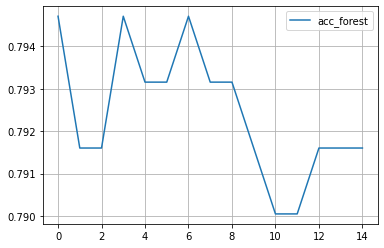

In [17]:
est_forest(1, 1500, 99)

Лучшее значение accuracy = 0.7947122861586314  
График показывает 3 максимума. От 1 до 100, в районе 397 и в районе 694.  
Рассмотрим подробнее все 3 промежутка.

Прогресc:
685  686  687  688  689  690  691  692  693  694  695  696  697  698  699  700  701  702  703  704  
Лучшая accuracy: 0.7947122861586314


RandomForestClassifier(n_estimators=685, random_state=54321)

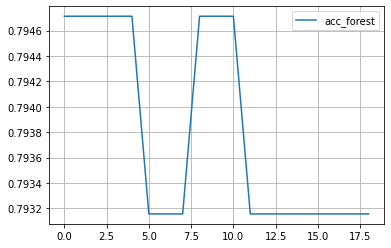

In [18]:
est_forest(685,705,1)

На промежутке (685, 705) несколько максимумов, но все не превышают 0.7947122861586314

Прогресc:
385  386  387  388  389  390  391  392  393  394  395  396  397  398  399  400  401  402  403  404  
Лучшая accuracy: 0.7947122861586314


RandomForestClassifier(n_estimators=396, random_state=54321)

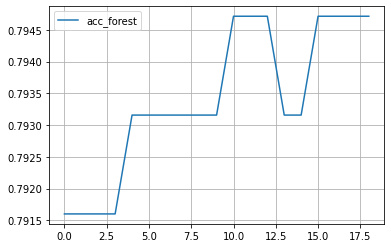

In [19]:
est_forest(385,405,1)

На промежутке (385, 405) несколько максимумов, но все не превышают 0.7947122861586314


Лучшая accuracy: 0.8009331259720062


RandomForestClassifier(n_estimators=36, random_state=54321)

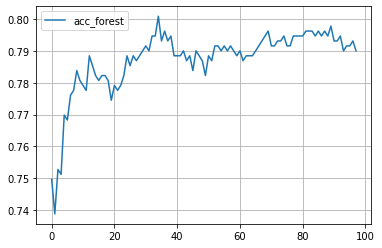

In [20]:
est_forest(1, 100, 1, False)

На промежутке (1, 100) максимум равен 0.8009331259720062, это лучший показатель accuracy.  
Количество деревьев в лесу - 36.  
Дальше будем работать с лесом в 36 деревьев. 

Переберем остальные гиперпараметры (max_depth, min_samples_split и min_samples_leaf) во вложенных циклах.  
**Перебор 3 параметров во вложенных циклах занимает продолжительное время.**

Прогресс:
1  8  15  22  29  36  
Максимальное значение accuracy: 0.8040435458786936 
Лучшая модель: RandomForestClassifier(max_depth=28, n_estimators=36, random_state=54321)


<AxesSubplot:>

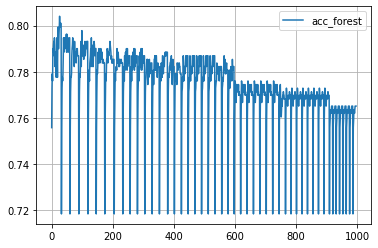

In [21]:
a = []
n = 4  # количество подряд идущих одинаковых значений accuracy, для досрочного выхода из цикла
model_forest_best = 0
best_accuracy, acc = 0, 0
print('Прогресс:')
for leaf in range(1, 37, 7):
    print(leaf, ' ', end='')  
    for split in range(2, 53, 7):
        depth_break = []
        for depth in range(1, 100, 1):
            model_forest = RandomForestClassifier(n_estimators=36, random_state=54321, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
            model_forest.fit(features_train, target_train)
            prediction_forest = model_forest.predict(features_valid)
            acc = accuracy_score(target_valid, prediction_forest)
            depth_break.append(acc)
            a.append(acc)
            if acc >= best_accuracy:
                best_accuracy = acc
                model_forest_best = model_forest
#                print('best ------ ', best_accuracy, depth, split, leaf)
            if loop_break(depth_break, acc, n) : break
               
print('\nМаксимальное значение accuracy:', best_accuracy, '\nЛучшая модель:', model_forest_best)
pd.DataFrame({'acc_forest':a[1:]}).plot(grid=True)

На графике виден один максимум соответствующий лесу из 36 деревьев с глубиной 28, потом правильность модели начинает снижаться.

In [22]:
error_count(target_valid, model_forest_best.predict(features_valid))
pass

Количество правильных ответов - 517, неправильных - 126, всего - 643, правильных - 80.4 %


In [23]:
accuracy_score(target_valid, model_forest_best.predict(features_valid))

0.8040435458786936

**Вывод:**  
Изменяя гиперпараметры получилось улучшить модель с 511 (79.47 %) правильных ответов, до 517 (80.4 %) на валидационной выборке.
Лучшая модель дерева решений: RandomForestClassifier(max_depth=28, n_estimators=36, random_state=54321).  
Модель Случайный лес хорошо справляется и с параметрами по умолчанию, подбирая гиперпараметры получилось улучшить модель незначительно.  



### Логистическая регрессия

Создадим и обучим модель логистическая регрессия с параметрами по умолчанию.

In [24]:
def get_logreg(iter=100):
    model_logreg_norm = LogisticRegression(random_state=54321, solver='lbfgs', max_iter=iter)
    model_logreg_norm.fit(features_train, target_train)
    return {'model' : model_logreg_norm, 'predict' : model_logreg_norm.predict(features_valid)}

model_logreg_norm = get_logreg()
accuracy_score(target_valid, model_logreg_norm['predict'])

0.6734059097978227

In [25]:
model_logreg_norm['model'].score(features_valid, target_valid)

0.6734059097978227

Значение accuracy равно 0.6734059097978227

In [26]:
error_count(target_valid, model_logreg_norm['model'].predict(features_valid))
pass

Количество правильных ответов - 433, неправильных - 210, всего - 643, правильных - 67.34 %


Пока модель логистическая регрессия показывает худшие результаты.  
Попробуем подобрать гиперпараметры.

Переберем значения гиперпараметра "количество итераций" в цикле.

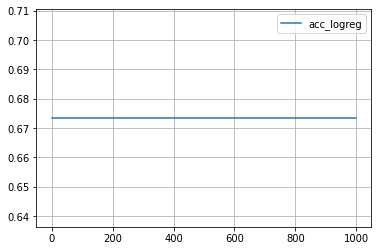

In [27]:
acc = []
for i in range(30, 50000, 50):
    acc.append(get_logreg(i)['model'].score(features_valid, target_valid))
pd.DataFrame({'acc_logreg':acc}).plot(grid=True)
pass

Из графика следует, что на модели логистическая регрессия на предоставленных данных метрика accuracy от гиперпараметра "количество итераций" не зависит. 

**Вывод:**  
Модель логистическая регрессия показала следующие результаты:  
Количество правильных ответов - 433, неправильных - 210, всего - 643, правильных - 67.34 %  
Accuracy равно 0.6734059097978227  
Изменение гиперпараметра на результат не повлияло.

**Общий вывод по 3 пункту:**  
`Дерево решений` с гиперпараметрами:  
по умолчанию - Количество правильных ответов - 460, неправильных - 183, всего - 643, правильных - 71.54 %  
подобранные - Количество правильных ответов - 510, неправильных - 133, всего - 643, правильных - 79.32 %  
`Случайный лес` с гиперпараметрами:  
по умолчанию - Количество правильных ответов - 511, неправильных - 132, всего - 643, правильных - 79.47 %  
подобранные - Количество правильных ответов - 517, неправильных - 126, всего - 643, правильных - 80.4 %  
`Логистическая регрессия` с гиперпараметрами:  
по умолчанию - Количество правильных ответов - 433, неправильных - 210, всего - 643, правильных - 67.34 %  
подобранные - Количество правильных ответов - 433, неправильных - 210, всего - 643, правильных - 67.34 %  

Наилучшие результаты показала модель СЛУЧАЙНЫЙ ЛЕС с подобранными гиперпараметрами, но и времени на расчеты потребовала значительно больше, чем остальные модели.  
Лучшая модель - RandomForestClassifier(max_depth=28, n_estimators=36, random_state=54321)  
Лучшая accuracy - 0.8040435458786936  

Модель `случайный лес` с парамертрами по умолчанию показывает такие же результаты, как модель `дерево решений` с подобранными гиперпараметрами.  

Самые плохие результаты показала модель - логистическая регрессия.  
Accuracy - 0.6734059097978227

## Проверьте модель на тестовой выборке

### Проверим модель дерево решений на тестовой выборке.

In [28]:
print('Дерево решений, лучшая модель, accuracy равно:')
accuracy_score(target_test, model_tree_best.predict(features_test))

Дерево решений, лучшая модель, accuracy равно:


0.833592534992224

In [29]:
print('Дерево решений, модель по умолчанию, accuracy равно:')
accuracy_score(target_test, model_tree_norm.predict(features_test))

Дерево решений, модель по умолчанию, accuracy равно:


0.7433903576982893

In [30]:
error_count(target_test, model_tree_best.predict(features_test))
pass

Количество правильных ответов - 536, неправильных - 107, всего - 643, правильных - 83.36 %


**Вывод:**  
Модель Дерево Решений с подобранными гиперпараметрами показала на тестовой выборке результат - `536 (83.36 %)` правильных ответов.

### Проверим модель случайный лес на тестовой выборке.

In [31]:
print('Случайный лес, лучшая модель, accuracy равно:')
accuracy_score(target_test, model_forest_best.predict(features_test))

Случайный лес, лучшая модель, accuracy равно:


0.8289269051321928

In [32]:
print('Случайный лес, модель по умолчанию, accuracy равно:')
accuracy_score(target_test, model_forest_norm.predict(features_test))

Случайный лес, модель по умолчанию, accuracy равно:


0.8273716951788491

In [33]:
error_count(target_test, model_forest_best.predict(features_test))
pass

Количество правильных ответов - 533, неправильных - 110, всего - 643, правильных - 82.89 %


**Вывод:**  
Модель Случайный лес с подобранными гиперпараметрами показала на тестовой выборке результат - `533 (82.89 %)` правильных ответов.

### Проверим модель логистическая регрессия на тестовой выборке.

In [34]:
print('Логистическая регрессия, accuracy равно:')
accuracy_score(target_test, model_logreg_norm['model'].predict(features_test))

Логистическая регрессия, accuracy равно:


0.7340590979782271

In [35]:
error_count(target_test, model_logreg_norm['model'].predict(features_test))
pass

Количество правильных ответов - 472, неправильных - 171, всего - 643, правильных - 73.41 %


**Вывод:**  
Модель Логистическая регрессия показала на тестовой выборке результат - `472 (73.41 %)` правильных ответов.

**Вывод:**  
Проверка на тестовой выборке показала следующие результаты:  
   - 1. Дерево Решений с подобранными гиперпараметрами правильных предсказаний - `536 (83.36 %)`.    
   - 2. Случайный Лес с подобранными гиперпараметрами правильных предсказаний - `533 (82.89 %)`.  
   - 3. Логистическая регрессия правильных предсказаний - `472 (73.41 %)`.

In [37]:
error_count(target_valid, model_forest_best.predict(features_valid))
pass

Количество правильных ответов - 517, неправильных - 126, всего - 643, правильных - 80.4 %


На тестовых данных эта модель показывает следующие результаты:

In [40]:
error_count(target_test, model_forest_norm.predict(features_test))
pass

Количество правильных ответов - 532, неправильных - 111, всего - 643, правильных - 82.74 %


Объединим обущающие и валидационные данные, еще раз обучим модель с этими гиперпараметрами и проверим на тестовой выборке конечный результат.

In [47]:
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])
pass

In [48]:
model = RandomForestClassifier(max_depth=28, n_estimators=36, random_state=54321)
model.fit(features_train_valid, target_train_valid)
error_count(target_test, model.predict(features_test))
pass

Количество правильных ответов - 522, неправильных - 121, всего - 643, правильных - 81.18 %


Модель обученная на объединенных данный показала на тестовой выборке более низкие результаты. Похоже переобучилась.

## Проверьте модели на адекватность

Проверка категорийной модели на адекватность производится с помощью случайной модели.  
В нашем случае можно считать, что accuracy случайной модели равно 0.5  
Наши модели показывают лучший результат.  
На всякий случай проверим.

Создадим целевую тестовую выборку со случайными значениями.

In [41]:
target_test_random = target_test.copy()
target_test_random[:] = [randint(0, 1) for i in range(len(target_test_random))]
target_test_random_0 = target_test.copy()
target_test_random_0[:] = 0
#target_test_random_0

Сравним целевую тестовую выборку со случайными значениями.

In [42]:
accuracy_score(target_test, target_test_random)

0.48367029548989116

In [43]:
accuracy_score(target_test, target_test_random_0)

0.7153965785381027

**Вывод:**  
Сравнение целевой тестовой выбоки со случайной моделью показывает значение accuracy около 0.5  
Наши модели показывают значения accuracy от 0,7341 до 0,8336  
Следовательно все наши модели адекватны. 


**Вывод:**  
В данном проекте на предоставленных данных получилось достичь значения accuracy равного `83.36 %`, правильно предсказать `536` значений из `643`.    

В итоге на тестовых данных лучший результат показала модель `дерево решений` с подобранными гиперпараметрами. Что оказалось несколько неожиданно, так как все исследование лидировала модель `случайный лес` с подобранными гиперпараметрами.  
Лучшая модель - `DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, min_samples_split=56, random_state=54321)`  
Модель `случайный лес` отстала на 3 правильных предсказания и на тестовой выборке показала результат `82.89 %`.

